# OpenFE Showcase: Relative Binding Free Energy of T4 Lysozyme


# Intro

* OpenFE lets you mix and match stuff -- in this notebook we focus on showing off everything you can do
* See [links] for tutorial style notebooks


## 0. Setup for Google Colab
TODO:  Clean this up and see if we can make it clean + hide it

If you are running this example in Google Colab, run the following cells to setup the environment. If you are running this notebook locally, skip down to `1. Overview`

In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/OpenFreeEnergy/ExampleNotebooks/releases/download/april-2023/OpenFEforge-June-2023-Linux-x86_64.sh")

⏬ Downloading https://github.com/OpenFreeEnergy/ExampleNotebooks/releases/download/april-2023/OpenFEforge-June-2023-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:01:32
🔁 Restarting kernel...


In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    import condacolab
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mkdir inputs && cd inputs && openfe fetch rbfe-showcase
    for _ in range(3):
      # Sometimes we have to re-run the check
      try:
        condacolab.check()
      except:
        pass
      else:
        break

Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/181L_mod_capped_protonated.pdb
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/Jnk1_ligands.sdf
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/benzene.sdf
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/ligands.sdf
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/styrene.sdf
✨🍰✨ Everything looks OK!


## 1. Overview

introduce tyk2 system 

### Alchemical transformations of tyk2 ligands

use our tools to load and viz ligands

### The plan

Here is what we will achieve in this notebook and what software toolchains are
used along the way.

TODO Update this to include cinnabun 

| **Actions**                    | **Software**                                                |
|:------------------------------:|:-----------------------------------------------------------:|
| Create OpenFE Molecules        | OpenFE  RDKit                                            |
| Create Radial Network          | OpenFE  Lomap, Networkx                                  |
| Visualise Network              | OpenFE  NetworkX, RDKit, Matplotlib                      |
| Create ligand topologies       | OpenFE interface - OpenFF tk                             |
| Create hybrid OpenMM topology  | OpenFE interface - OpenMMTools (eventually - ex Perses)  |
| Create Lambda Protocol         | OpenFE interface - OpenMMTools (eventually - ex Perses)  |
| Setup and run RBFE calculation | OpenFE interface - OpenMM + OpenMMTools                  |
| Analysis RBFE calculation      | OpenFE interface - PyMBAR + OpenMMTools                  |


A complete overview of the setup and simulation process starting from initial SDF and PDB files can be found [in this diagram](./assets/RBFE_workflow.drawio.pdf).

## 2. Creating a transformation network

### Creating OpenFE SmallMoleculeComponents

In order to keep track of the various inputs being passed through the OpenFE
toolkit, OpenFE implements a set of Components which define the proteins,
small molecules and solvent components which a system may contain. Here we
use the [SmallMoleculeComponent](https://github.com/OpenFreeEnergy/gufe/blob/main/gufe/smallmoleculecomponent.py)
which takes in either [RDKit molecules](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)
or [OpenFF molecules](https://open-forcefield-toolkit.readthedocs.io/en/0.9.2/api/generated/openff.toolkit.topology.Molecule.html).

In the backend, OpenFE treats the RDKit molecules as the central representation
of the ligands, and uses the OpenFF toolkit to convert between objects from
various toolchains (for example OpenEye's OEMol).

Here we demonstrate how to load the ligands from `inputs/ligands.sdf` into a
list of OpenFE SmallMoleculeComponents for further processing.

TODO: Show loading molecule using openff tk 

In [2]:
from openfe import SmallMoleculeComponent

# Create and SDF supplier
# Extract the contents of the sdf file and visualise it
ligands_sdf = Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

OpenFE SmallMoleculeComponents have some useful built in attributes and methods.

For example the molecule's name (as defined by the SDF file) can be accessed

In [3]:
print("name: ", ligand_mols[0].name)

name:  benzene


As previously stated SmallMoleculeComponents also use the OpenFF backend to allow conversion between different object types. For example it's possible to obtain an openff Molecule:

In [5]:
type(ligand_mols[0].to_openff())

openff.toolkit.topology.molecule.Molecule

### Creating a network

From these SmallMoleculeComponents we can quickly create a star map network which centers
around the first ligand in our sdf file (benzene) using
`openfe.setup.ligand_network_planning.generate_radial_network`.

Here we use Lomap (via the OpenFE interface LomapAtomMapper) to define the atom mappings between the various ligands and the central benzene structure. Whilst
we use the defaults here, please note that the various supported arguments of
Lomap can be passed to LomapAtomMapper.

Note: LomapAtomMapper is one of three currently implemented Mappers in OpenFE,
the other two being the Kartograf atom mapper and the rjmc mapper from Perses. Long term, users will be able to pass serveral
mappers and atom mapping scoring methods on network generation.

TODO show off different network types

TODO add karto-graph-o

In [6]:
# Create network from the two molecules
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup import LomapAtomMapper

network = generate_radial_network(ligands=ligand_mols[1:],
                                  central_ligand=ligand_mols[0],
                                  mappers=[LomapAtomMapper(threed=True, element_change=False),])

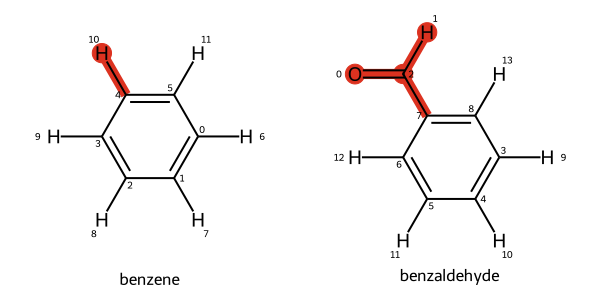

In [7]:
edges = [edge for edge in network.edges]
edge = edges[0]
edge

This network contains a set of 6 edges centered around the benzene molecule
which define the various atom mappings between the the transformation pairs.


Edges along the network can be accessed to recover the invidual molecules
involved in that given alchemical tranformation, and the atom mapping between
the two ligands.

**Note: as can be seen in the example below, transformations are defined within OpenFE as going from componentA to componentB**

In [8]:
transform_edges = [edge for edge in network.edges]
print("molecule A smiles: ", transform_edges[0].componentA.smiles)
print("molecule B smiles: ", transform_edges[0].componentB.smiles)
print("map between molecule A and B: ", transform_edges[0].componentA_to_componentB)

molecule A smiles:  c1ccccc1
molecule B smiles:  O=Cc1ccccc1
map between molecule A and B:  {0: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 11: 13}


We can also visualise the atom mappings by invoking the individual OpenFE
AtomMapping objects directly.

Here we show how to draw two mappings for benzene -> phenol and benzene -> anisole.

Unique atoms between each mapping are shown in red, and atoms which are mapped
but undergo element changes are shown in blue. Bonds which either involve atoms that are unique or undergo element changes are highlighted in red.

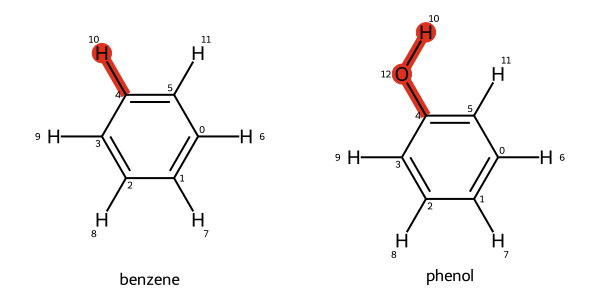

In [9]:
# Get the edge with phenol
edge = [edge for edge in network.edges if edge.componentB.name == "phenol"][0]
edge

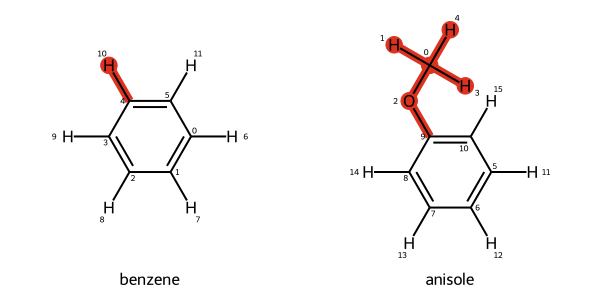

In [10]:
# Get edge for anisole
edge = [edge for edge in network.edges if edge.componentB.name == "anisole"][0]
edge

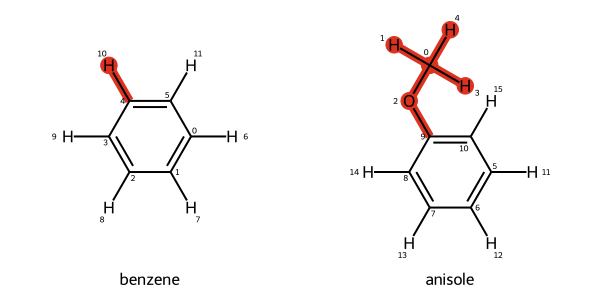

In [11]:
from IPython.display import Image

# mappings can also be saved to file if required
edge = [edge for edge in network.edges if edge.componentB.name == "anisole"][0]
edge.draw_to_file('benzene-to-anisole.png')

# load it back for visualisation
Image("benzene-to-anisole.png")

### Storing the network

Created networks can easily be converted to (and also loaded from) as a GraphML representation.

This can allow users of OpenFE to store the network to disk for later use.

MMH: I think keeping that you can store the network is fine but we don't need more than this + the small code snnipit 

In [14]:
# Convert to graphml
with open("network_store.graphml", "w") as writer:
    writer.write(network.to_graphml())

### The OpenFE CLI

The OpenFE toolkit also has a command line interface which we plan to add several convenience methods to.

For now functionality is limited to atom mapping, but it will be expanded upon as the project grows.

TODO: How about we move the CLI to the end and say "you can do x, y, and z" with the CLI (Or just say "Oh we also have a CLI tool and it can do everything you just read about in this notebook) 

In [17]:
# Call help on the OpenFE CLI
!openfe --help

Usage: openfe [OPTIONS] COMMAND [ARGS]...

  This is the command line tool to provide easy access to functionality from
  the OpenFE Python library.

Options:
  --version   Show the version and exit.
  --log PATH  logging configuration file
  -h, --help  Show this message and exit.

Network Planning Commands:
  view-ligand-network  Visualize a ligand network
  plan-rhfe-network    Plan a relative hydration free energy network, saved as
                       JSON files for the quickrun command.
  plan-rbfe-network    Plan a relative binding free energy network, saved as
                       JSON files for the quickrun command.

Quickrun Executor Commands:
  gather    Gather result jsons for network of RFE results into a TSV file
  quickrun  Run a given transformation, saved as a JSON file

Miscellaneous Commands:
  test   Run the OpenFE test suite
  fetch  Fetch tutorial or other resource.


## 3. Running a Relative Ligand Binding Free Energy Calculation

Now that we have a set of atom mappings defined, we know which atoms should
undergo alchemical transformations to capture the free energy cost of
transforming from one ligand to another.

To simulate this transformation we use the equilibrium RBFE protocol
implemented in OpenFE. This uses OpenMM to run a Perses-like relative
ligand binding free energy calculation using a single topology approach.

To achieve this simulation, the following steps need to happen:

1. Create OpenMM systems of both end states


2. Create a hybrid topology based on these defined endstates


3. Set an appropriate Lambda schedule


4. Set a MultiState reporter to write out appropriate coordinates and energies


5. Create an OpenMM sampler (in this case we will be using a replica exchange sampler)


6. Carry out the necessary simulation steps (minimization, equilibration, and production)


The `RelativeHybridTopologyProtocol` class in `openfe.protocols.openmm_rfe`
implements a means to achieve all the above with minimal intervention.

Here we work through its usage for the benzene -> phenol binding free energy
test case. As this involves both a relative binding free energy in solvent
and complex phases, the `RelativeHybridTopologyProtocol` Protocol will
be used to build two separate `ProtocolDAG` (directed-acyclic-graph) classes, one for each phase.
These `DAG`s (which contain the necessary individual simulations), are then executed to yield
the desired free energy results.

**Note: the underlying components used for the creation of OpenMM hybrid
topologies and samplers is still in flux, originating mostly from Perses.
Please consider these to be in beta.**

### Defining the ChemicalSystems

`ChemicalSystems` are OpenFE containers which define the various components
which exist in a system of interest. You can consider these to be the nodes
along an alchemical network which are connected by edges which carry out
calculations along Alchemical states to get free energies.

`ChemicalSystems` take in three different things:

1. A dictionary of the chemical components (e.g. `SmallMoleculeComponent`,
   `ProteinComponent`, `SolventComponent`) defining the system.


2. Box vectors (optional), defining the shape and size of the unit cell of the
   system.


3. An identifier name (optional), for the `ChemicalSystem`. This is used as part
   of the hash identifier of the `ChemicalSystem`, and can help distinguish between
   otherwise comparable systems.

In the case of a relative ligand binding free energy calculation for benzene -> phenol,
four `ChemicalSystems` must be defined:

1. Benzene in complex with T4 lysozyme in a box of water


2. Phenol in complex with T4 lysozyme in a box of water


3. Benzene in a box of water


4. Phenol in a box of water


Here we will be passing the previously defined `SmallMoleculeComponents` for benzene
and phenol. We will also pass a `ProteinComponent` generated from the PDB file
present under `inputs/181L_mod_capped_protonated.pdb`. Finally, instead of passing
in a specific box of water, we will define a `SolventComponent` which will contain
the necessary information for OpenMM's `Modeller` class to add water and 0.15 M NaCl
around the solute when creating the OpenMM simulation objects.

In [20]:
# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent, ProteinComponent
from openff.units import unit

protein = ProteinComponent.from_pdb_file('inputs/181L_mod_capped_protonated.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

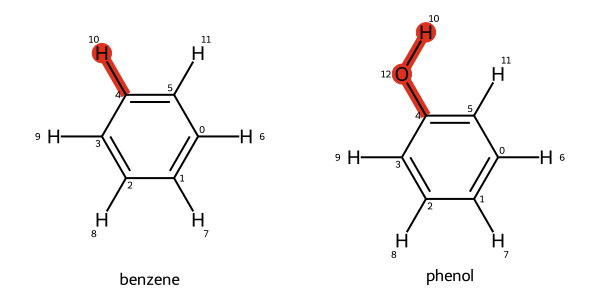

In [21]:
# Extract the relevant edge for the benzene -> phenol transform in the radial graph
benz_to_phenol = [edge for edge in network.edges if edge.componentB.name == "phenol"][0]

benz_to_phenol

In [22]:
# Let's create the four ChemicalSystems
from openfe import ChemicalSystem

benzene_complex = ChemicalSystem({'ligand': benz_to_phenol.componentA,
                                  'solvent': solvent,
                                  'protein': protein,})
benzene_solvent = ChemicalSystem({'ligand': benz_to_phenol.componentA,
                                  'solvent': solvent,})

phenol_complex = ChemicalSystem({'ligand': benz_to_phenol.componentB,
                                 'solvent': solvent,
                                 'protein': protein,})
phenol_solvent = ChemicalSystem({'ligand': benz_to_phenol.componentB,
                                 'solvent': solvent,})

### Defining the RBFE simulation settings

TODO: replace this with "we provide reasonable defaults and they are easy to modify"



1. `protocol_repeats`: The number of completely independent repeats of the entire sampling process.

2. `simulation_settings`: Parameters controling the simulation plan and the alchemical sampler, including the number of minimization steps, lengths of equilibration and production runs, the sampler method (e.g. Hamiltonian replica exchange, `repex`), and the time interval at which to perform an analysis of the free energies.

3. `output_settings`: Simulation output control settings, including the frequency to write a checkpoint file, the selection string for which part of the system to write coordinates for, and the paths to the trajectory and output structure storage files.

4. `alchemical_settings`: Parameters controlling the creation of the hybrid topology system. This includes various parameters ranging from softcore parameters, through to whether or not to apply an explicit charge correction for systems with net charge changes.

5. `engine_settings`: Parameters determining how the OpenMM engine will execute the simulation. This controls the compute platform which will be used to carry out the simulation.

6. `integrator_settings`: Parameters controlling the `LangevinSplittingDynamicsMove` integrator used for simulation.

7. `lambda_settings`: Lambda protocol settings, including number of lambda windows and lambda functions.

8. `forcefield_settings`: Parameters to set up the force field with OpenMM Force Fields, including the general forcefields, the small molecule forcefield, the nonbonded method, and the nonbonded cutoff.

9. `thermo_settings`: Settings for thermodynamic parameters, such as the temperature and the pressure of the system.

10. `solvation_settings`: Settings for solvating the system, including the solvent model and the solvent padding.

11. `partial_charge_settings`: Settings for assigning partial charges to small molecules, including the partial charge method (e.g. `am1bcc`) and the openff toolkit backend (e.g. `ambertools` or `openeye`).

In [1]:
# Show importing default and change 1 or 2 settings

### Creating the RelativeLigandTransform Protocol

With the Settings inspected and adjusted, we can provide these to the Protocol.
This Protocol defines the procedure to estimate a free energy difference between two chemical systems,
with the details of the two end states yet to be defined.

In [31]:
# Create RBFE Protocol class
rbfe_transform = RelativeHybridTopologyProtocol(
    settings=rbfe_settings
)

### Simulating the RelativeLigandTransforms

Individual Units can then be executed by calling the `.execute()` method.

In the first instance we do a dry-run (which does everything but
starting the simulation) to make sure that the
hybrid openmm system can be constructed without any issues.
Note: A successful call to `.run()` will return an empty Dictionary.

In [ ]:
# complex dry-run
complex_unit = list(complex_dag.protocol_units)[0]

complex_unit.run(dry=True, verbose=True)

In [ ]:
# solvent dry-run
solvent_unit = list(solvent_dag.protocol_units)[0]

solvent_unit.run(dry=True, verbose=True)

### Executing the simulations.

TODO: explain here there are 4 ways to run sims, quick run, exorcist, alchemiscale, python API

## 4. Analysis

Finally now that we've run our simulations, let's go ahead and gather the free
energies for both phases.

This can be achieved by passing the results of executing the DAGs calling the `gather()` methods of `RelativeLigandTransform`.
This takes a **list** of completed DAG results, catering for when simulations have been extended.

TODO: add cinnabar

In [39]:
# Get the complex and solvent results
complex_results = rbfe_transform.gather([complex_dag_results])
solvent_results = rbfe_transform.gather([solvent_dag_results])

print(f"Complex dG: {complex_results.get_estimate()}, err {complex_results.get_uncertainty()}")
print(f"Solvent dG: {solvent_results.get_estimate()}, err {solvent_results.get_uncertainty()}")

Complex dG: 3.8428725693840384 kilocalorie / mole, err 0.21918456914295942 kilocalorie / mole
Solvent dG: 1.206767244454323 kilocalorie / mole, err 0.32073333466272824 kilocalorie / mole
